In [7]:
"""
This Program Evaluates and Predicts O-PPAC data using a Fully Connected Neural Network
@author: Ted Yoo
"""

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import Modules as mod
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [8]:
def main():
    #Extracts data from h5 file
    dataset = h5py.File('simu_HDF_new.h5', 'r')
    num_diodes = dataset['Num_diodes'][...]
    x_pos = (dataset['Xpos'][...])/100
    y_pos = dataset['Ypos'][...]
    histgrid = dataset['histgrid'][...]
    dataset.close()
    
    #Defines Scalers used to scale inputs and outputs
    input_scaler = MinMaxScaler()
    output_scaler = StandardScaler()
    
    #Put Compile all data and their labels
    all_data, all_labels = mod.data_compile(histgrid, x_pos)
    
    #Split Train, Validation and Test datasets
    train_data, val_data, test_data, train_labels, val_labels, test_labels = mod.data_split(all_data, all_labels, 0.2, 0.25)
    
    #Reshape Labels for Scaling
    train_labels = train_labels.reshape(-1,1)
    val_labels = val_labels.reshape(-1,1)
    test_labels = test_labels.reshape(-1,1)
    
    #Scale both Inputs and Outputs
    train_data, val_data, test_data = mod.TVT_scaler(input_scaler, train_data, val_data, test_data)
    train_labels, val_labels, test_labels = mod.TVT_scaler(output_scaler, train_labels, val_labels, test_labels)
    
    #Train and Evaluate Fully Connect Neural Network Model
    FCNN_history, result, predictions = mod.train_FCNN_model(train_data, train_labels, val_data, val_labels, test_data, test_labels)
    
    #Inverse Transform scaled Labels and Predictions
    test_rescale_labels = output_scaler.inverse_transform(test_labels)
    predictions_rescale = output_scaler.inverse_transform(predictions)
    
    #Plot Loss Curve
    plt.figure(1)
    plt.plot(FCNN_history.history['loss'], label='loss')
    plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 0.1])
    plt.legend(loc='upper right')
    plt.title("FCNN O-PPAC Loss Curve")
    
    #Plot Predictions vs True Values
    plt.figure(2)
    a = plt.axes(aspect='equal')
    plt.scatter(test_rescale_labels, predictions_rescale)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [-50, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.title("FCNN O-PPAC Predictions vs True Values")

Train on 5454 samples, validate on 1818 samples
Epoch 1/100
5454/5454 [==============================] - 1s 238us/sample - loss: 0.0600 - mae: 0.1741 - mse: 0.0600 - val_loss: 0.0228 - val_mae: 0.1111 - val_mse: 0.0228
Epoch 2/100
5454/5454 [==============================] - 1s 126us/sample - loss: 0.0328 - mae: 0.1290 - mse: 0.0328 - val_loss: 0.0126 - val_mae: 0.0817 - val_mse: 0.0126
Epoch 3/100
5454/5454 [==============================] - 1s 128us/sample - loss: 0.0234 - mae: 0.1082 - mse: 0.0234 - val_loss: 0.0139 - val_mae: 0.0879 - val_mse: 0.0139
Epoch 4/100
5454/5454 [==============================] - 1s 127us/sample - loss: 0.0202 - mae: 0.0996 - mse: 0.0202 - val_loss: 0.0056 - val_mae: 0.0540 - val_mse: 0.0056
Epoch 5/100
5454/5454 [==============================] - 1s 120us/sample - loss: 0.0186 - mae: 0.0943 - mse: 0.0186 - val_loss: 0.0089 - val_mae: 0.0590 - val_mse: 0.0089
Epoch 6/100
5454/5454 [==============================] - 1s 128us/sample - loss: 0.0176 - mae: 0.

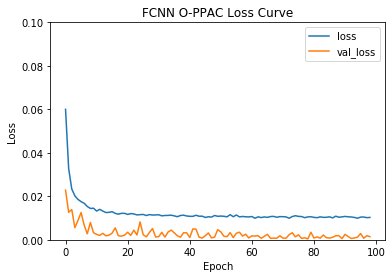

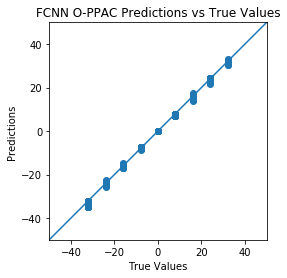

In [9]:
if __name__ == "__main__":
    main()